# LSTM Autoencoders with MFCCs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import IPython
import time
import random
import torch
import torchaudio
import librosa
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import sys
sys.path.append("..")
from dataset_generation.randomDataset import RandomDataset

from torch import nn
from torch.nn import functional as F

/home/amosyou/.conda/envs/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# LSTM autoencoder
# credit: https://github.com/hellojinwoo/TorchCoder/blob/master/autoencoders/rae.py
class Encoder(nn.Module):
    def __init__(self, seq_len, no_features, embedding_size):
        super().__init__()
        
        self.seq_len = seq_len
        self.no_features = no_features    # The number of expected features(= dimension size) in the input x
        self.embedding_size = embedding_size   # the number of features in the embedded points of the inputs' number of features
        self.LSTM1 = nn.LSTM(
            input_size = no_features,
            hidden_size = self.embedding_size,
            num_layers = 1,
            batch_first=True
        )
        
    def forward(self, x):
        # Inputs: input, (h_0, c_0). -> If (h_0, c_0) is not provided, both h_0 and c_0 default to zero.
        # Outputs: output, (h_n, c_n)
        _, (hidden_state, cell_state) = self.LSTM1(x)  
        last_lstm_layer_hidden_state = hidden_state[-1,:,:]
        return last_lstm_layer_hidden_state
    
    
# (2) Decoder
class Decoder(nn.Module):
    def __init__(self, seq_len, embedding_size, output_size):
        super().__init__()

        self.seq_len = seq_len
        self.embedding_size = embedding_size
        self.output_size = output_size
        self.LSTM1 = nn.LSTM(
            input_size = self.embedding_size,
            hidden_size = 2 * self.embedding_size,
            num_layers = 1,
            batch_first = True
        )
        
        self.fc = nn.Linear(2 * self.embedding_size, self.output_size)
        
    def forward(self, x):
        # input is a embedding_dim x 1 vector
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)
        x, (hidden_state, cell_state) = self.LSTM1(x)
        x = x.reshape((-1, self.seq_len, 2 * self.embedding_size))
        out = self.fc(x)
        return out
    
    
# (3) Autoencoder : putting the encoder and decoder together
class LSTM_AE(nn.Module):
    def __init__(self, seq_len, no_features, embedding_dim):
        super().__init__()
        
        self.seq_len = seq_len
        self.no_features = no_features
        self.embedding_dim = embedding_dim

        self.encoder = Encoder(self.seq_len, self.no_features, self.embedding_dim)
        self.decoder = Decoder(self.seq_len, self.embedding_dim, self.no_features)
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

cuda
shape of feature: torch.Size([1, 20, 126])
datatype torch.float32


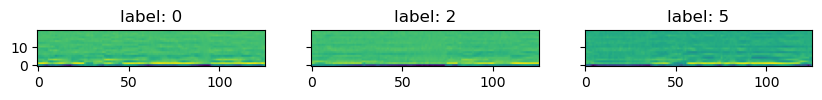

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
loss = torch.nn.CrossEntropyLoss()

src = '../dataset_generation/speeches'
nfft=512
nmels=60
mfcc = torchaudio.transforms.MFCC(sample_rate=16000, n_mfcc=20, melkwargs={'n_fft':nfft, 'n_mels':nmels})
# cmn = torchaudio.transforms.SlidingWindowCmn(cmn_window=100, center=True, norm_vars=True)

dataSet = RandomDataset(src, 16000, 1000, mfcc, 3, 2)
train_data, val_data = torch.utils.data.random_split(dataSet, (800, 200))
input_shape = None
train_dl = DataLoader(train_data, batch_size=4)
val_dl = DataLoader(val_data, batch_size=4)

fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
for i in range(3):
    img, label = val_data[i]
    if i==0:
        print('shape of feature:', img.shape)
        print('datatype', img.dtype)
        input_shape = img.shape
    axs[i].imshow(img[0].cpu(), origin='lower')
    axs[i].set_title(f'label: {label}')

In [ ]:
def check_nan(data):
    for i in range(len(data)):
        minibatch = data[i][0]
        if torch.isinf(minibatch).sum():
            return True
    return False

check_nan(train_data)

In [4]:
model = LSTM_AE(seq_len=126, no_features=20, embedding_dim=128)

model = model.to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss = torch.nn.MSELoss()

LSTM_AE(
  (encoder): Encoder(
    (LSTM1): LSTM(20, 128, batch_first=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(128, 256, batch_first=True)
    (fc): Linear(in_features=256, out_features=20, bias=True)
  )
)


In [12]:
def train_epoch(model, train_data_loader, val_data_loader, loss_fn, opt, device, metrics):

    model.train()
    losses = []
    accuracies = []
    for input, target in train_data_loader:
        # disregard labels for autoencoder reconstruction loss

        batch_size = input.shape[0]
        n_dim = input.shape[2]
        length = input.shape[3]

        # input dimensions for LSTMs: (batch_size, length, n_dim)
        input = torch.reshape(input, (batch_size, length, n_dim))
        input = (input - input.mean()) / input.std()
        input = input.to(device)

        # calculate loss
        prediction = model(input)
        loss = loss_fn(prediction, input)
        accuracies.append((prediction == input).float().mean())
        losses.append(loss.item())

        # backpropagate error and update weights
        opt.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        opt.step()
    
    metrics['t_acc'].append((sum(accuracies)/len(accuracies)).cpu())
    metrics['t_loss'].append((sum(losses)/len(losses)))
    
    model.eval()
    losses = []
    accuracies = []
    for input, target in val_data_loader:
        batch_size = input.shape[0]
        n_dim = input.shape[2]
        length = input.shape[3]

        input = torch.reshape(input, (batch_size, length, n_dim))
        input, target = input.to(device), target.to(device)
        prediction = model(input)

        loss = loss_fn(prediction, input)
        accuracies.append((prediction == input).float().mean())
        losses.append(loss.item())
    
    metrics['v_acc'].append((sum(accuracies)/len(accuracies)).cpu())
    metrics['v_loss'].append((sum(losses)/len(losses)))

****** STARTING TRAINING ******
Finished epoch: 0; Training loss: 0.2359492177516222
Finished epoch: 1; Training loss: 0.2192789091542363
Finished epoch: 2; Training loss: 0.21796459190547465
Finished epoch: 3; Training loss: 0.2180206198245287
Finished epoch: 4; Training loss: 0.21649258244782688
Finished epoch: 5; Training loss: 0.22000736597925424
Finished epoch: 6; Training loss: 0.21806534830480814
Finished epoch: 7; Training loss: 0.2181627520546317
Finished epoch: 8; Training loss: 0.2168725610896945
Finished epoch: 9; Training loss: 0.21364180866628885
Finished epoch: 10; Training loss: 0.21399077940732242
Finished epoch: 11; Training loss: 0.20837848875671625
Finished epoch: 12; Training loss: 0.20882398061454296
Finished epoch: 13; Training loss: 0.2132004515454173
Finished epoch: 14; Training loss: 0.2094606936350465
Finished epoch: 15; Training loss: 0.21152306150645017
Finished epoch: 16; Training loss: 0.213964552693069
Finished epoch: 17; Training loss: 0.210275791101157

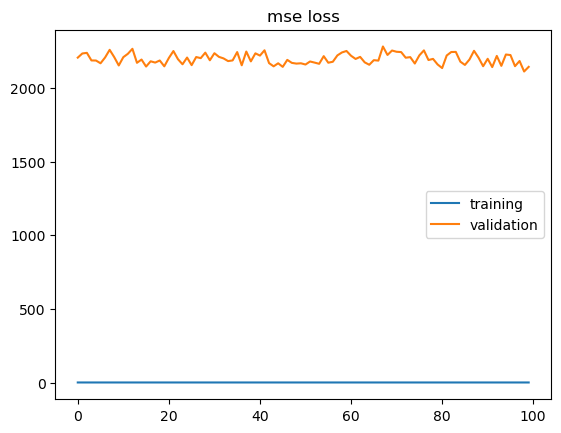

Text(0.5, 1.0, 'accuracy')

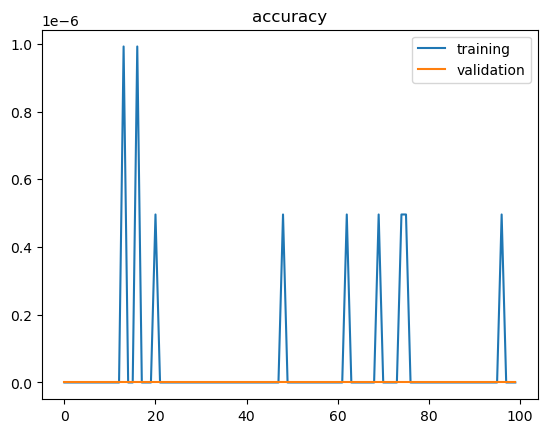

In [13]:
metrics = {
    't_loss': [],
    'v_loss': [],
    't_acc': [],
    'v_acc': []
}
print('****** STARTING TRAINING ******')
for epoch in range(100):
    train_epoch(model, train_dl, val_dl, loss_fn=loss, opt=optimizer, device=device, metrics=metrics)
    print(f"Finished epoch: {epoch}; Training loss: {metrics['t_loss'][-1]}")

print("Fininshed training")    
print('best validation accuracy', max(metrics['v_acc']).data)

plt.plot(metrics['t_loss'])
plt.plot(metrics['v_loss'])
plt.legend(['training', 'validation'])
plt.title('mse loss')
plt.show()

plt.figure(1)
plt.plot(metrics['t_acc'])
plt.plot(metrics['v_acc'])
plt.legend(['training', 'validation'])
plt.title('accuracy')

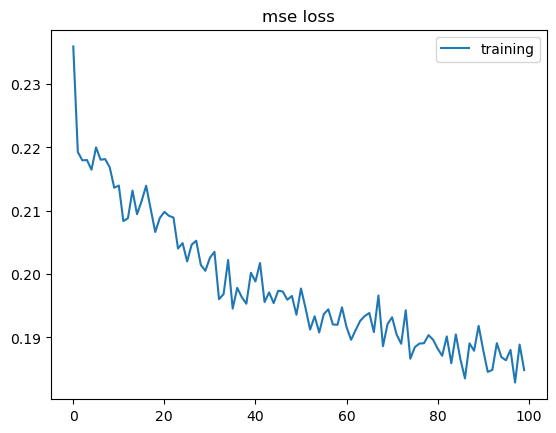

In [15]:
plt.plot(metrics['t_loss'])
plt.legend(['training', 'validation'])
plt.title('mse loss')
plt.show()

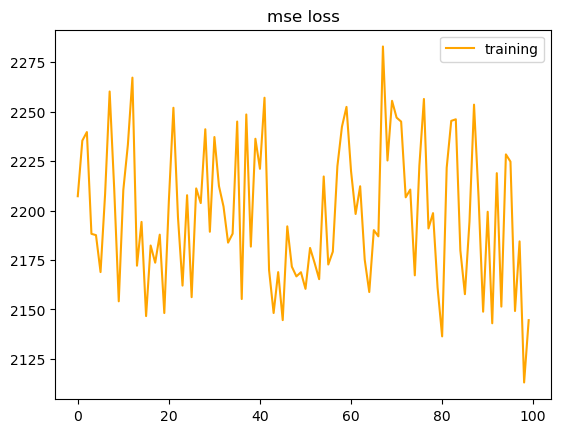

In [19]:
plt.plot(metrics['v_loss'], color='orange')
plt.legend(['training', 'validation'])
plt.title('mse loss')
plt.show()

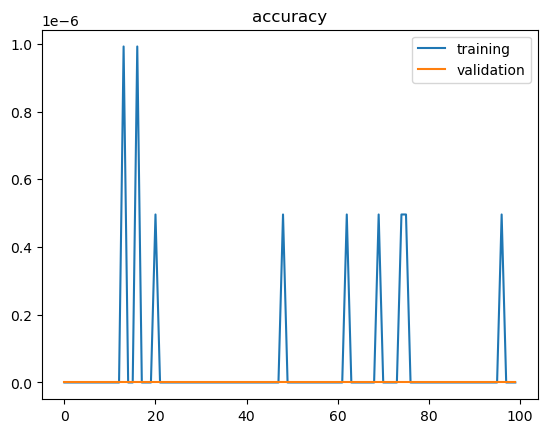

In [17]:
plt.plot(metrics['t_acc'])
plt.plot(metrics['v_acc'])
plt.legend(['training', 'validation'])
plt.title('accuracy')
plt.show()

In [20]:
model()

LSTM_AE(
  (encoder): Encoder(
    (LSTM1): LSTM(20, 128, batch_first=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(128, 256, batch_first=True)
    (fc): Linear(in_features=256, out_features=20, bias=True)
  )
)

In [90]:
torch.save(model, 'lstm_autoencoder_mfcc')

## Reconstruct Audio from MFCC

In [77]:
audio_0 = librosa.feature.inverse.mfcc_to_audio(train_data[0][0].numpy(), n_mels=60, n_fft=512)

In [78]:
audio_0

array([[-0.94901055, -1.3468101 , -1.3629318 , ..., -0.06583753,
        -0.05600117, -0.02958171]], dtype=float32)

In [79]:
len(audio_0[0])

16000

In [80]:
torchaudio.save('audio_0.wav', torch.Tensor(audio_0), 16000)

In [81]:
test_example = train_data[0][0].reshape(-1, 126, 20)
test_example = test_example.to(device)
test_example

tensor([[[-1.3521e+02, -1.3321e+02, -1.3964e+02,  ..., -2.7053e+02,
          -2.7780e+02, -2.8720e+02],
         [-2.8761e+02, -2.8976e+02, -2.8703e+02,  ..., -4.5948e+01,
          -5.8084e+01, -7.7629e+01],
         [-8.2836e+01, -6.0837e+01, -8.1681e+01,  ..., -1.2654e+01,
          -2.2512e+01, -2.3523e+01],
         ...,
         [ 6.3138e+00,  1.5377e+00, -1.0071e+00,  ...,  1.3610e+00,
           2.6820e+00,  6.6876e+00],
         [-3.1623e-02,  5.7075e+00,  4.5312e+00,  ..., -6.0162e+00,
          -7.7343e+00, -1.0909e+01],
         [-1.1625e+01, -7.0578e+00,  1.0365e+00,  ..., -7.8027e+00,
          -3.9764e+00, -2.1099e+00]]], device='cuda:0')

In [82]:
mfcc_reconstructed = model(test_example).cpu()
mfcc_reconstructed = mfcc_reconstructed.reshape(20, 126)
mfcc_reconstructed

tensor([[-0.9429, -1.0127, -0.9658,  ...,  1.9660,  2.0790,  1.9263],
        [ 2.2228,  2.0170,  2.0290,  ...,  0.2574,  0.1316,  0.1421],
        [ 0.3141,  0.1484,  0.3110,  ...,  0.4162,  0.3596,  0.2917],
        ...,
        [ 0.6387,  0.5408,  0.5326,  ...,  0.4542,  0.5332,  0.5254],
        [ 0.5021,  0.5307,  0.4462,  ...,  0.4409,  0.5024,  0.3766],
        [ 0.4680,  0.4853,  0.4257,  ...,  0.3577,  0.4816,  0.2994]],
       grad_fn=<ReshapeAliasBackward0>)

In [83]:
audio_0_reconstructed = librosa.feature.inverse.mfcc_to_audio(mfcc_reconstructed.detach().numpy(), n_mels=60, n_fft=512)
audio_0_reconstructed

array([-0.0960288 ,  0.42406014,  0.49390793, ...,  0.0811823 ,
        0.83964115,  0.304629  ], dtype=float32)

In [84]:
len(audio_0_reconstructed)

16000

In [85]:
torchaudio.save('audio_0_reconstructed.wav', torch.Tensor([audio_0_reconstructed]), 16000)

In [95]:
audio_1 = librosa.feature.inverse.mfcc_to_audio(train_data[1][0].numpy(), n_mels=60, n_fft=512)

test_example_1 = train_data[1][0].reshape(-1, 126, 20)
mfcc_reconstructed_1 = model(test_example_1.to(device)).cpu()
mfcc_reconstructed_1 = mfcc_reconstructed_1.reshape(1, 20, 126)

audio_1_reconstructed = librosa.feature.inverse.mfcc_to_audio(mfcc_reconstructed_1.detach().numpy(), n_mels=60, n_fft=512)

torchaudio.save('audio_1.wav', torch.Tensor(audio_1), 16000)
torchaudio.save('audio_1_reconstructed.wav', torch.Tensor(audio_1_reconstructed), 16000)